In [4]:
# # import sys
# # sys.path.append('/Users/pradap/Documents/Research/Python-Package/scaling/dmagellan/')
import pandas as pd

In [2]:
# imports
from dmagellan.blocker.attrequivalence.attr_equiv_blocker import AttrEquivalenceBlocker
from dmagellan.blocker.overlap.overlapblocker import OverlapBlocker
from dmagellan.blocker.blackbox.blackbox_blocker import BlackBoxBlocker
from dmagellan.blocker.rulebased.rule_based_blocker import RuleBasedBlocker
from dmagellan.feature.autofeaturegen import get_features_for_blocking
from dmagellan.feature.extractfeatures import extract_feature_vecs
from dmagellan.feature.autofeaturegen import get_features_for_matching
from dmagellan.matcher.dtmatcher import DTMatcher
from dmagellan.utils.py_utils.utils import concat_df
from dask import delayed
from dask.threaded import get
from distributed import Client
import py_entitymatching as em

In [8]:
client = Client()

In [5]:
orig_A = pd.read_csv('./citeseer_nonans.csv')
orig_B = pd.read_csv('./dblp_nonans.csv')

In [6]:
# sample datasets
A = pd.read_csv('./sample_citeseer.csv')
B = pd.read_csv('./sample_dblp.csv')

In [9]:
# blocking
ob = OverlapBlocker()
C = ob.block_tables(A, B, 'id', 'id', 'title', 'title', 
                    overlap_size=3, nltable_chunks=2, nrtable_chunks=2, 
                    scheduler=client.get, compute=False, 
                    rem_stop_words=True
                   )
# len(C)

In [6]:
# client.restart()

In [10]:
L = pd.read_csv('sample_labeled_data.csv')

In [11]:
F = em.get_features_for_matching(A, B)

In [12]:
# help(extract_feature_vecs)

In [13]:
# Convert L into feature vectors using updated F
H = extract_feature_vecs(L, orig_A, orig_B, 
                         '_id', 'l_id', 'r_id', 'id', 'id', 
                          feature_table=F, 
                          attrs_after='label', nchunks=4,
                          show_progress=False, compute=True, 
                         scheduler=client.get)

In [ ]:
# client.restart()

In [14]:
H.head()

,_id,l_id,r_id,id_id_exm,id_id_anm,id_id_lev_dist,id_id_lev_sim,title_title_jac_qgm_3_qgm_3,title_title_cos_dlm_dc0_dlm_dc0,title_title_mel,title_title_lev_dist,title_title_lev_sim,authors_authors_jac_qgm_3_qgm_3,authors_authors_cos_dlm_dc0_dlm_dc0,authors_authors_mel,authors_authors_lev_dist,authors_authors_lev_sim,label
0,0,401372,1446376,0,0.277502,4,0.428571,0.101604,0.181902,0.707672,94.0,0.318841,0.000000,0.000000,0.514006,26.0,0.235294,0
1,1,1349544,12210,0,0.009048,6,0.142857,0.828571,0.714286,0.916532,2.0,0.968750,0.580000,0.676123,0.864320,14.0,0.695652,1
2,2,1328193,1921746,0,0.691139,5,0.285714,0.900000,0.800000,0.995833,1.0,0.979167,1.000000,1.000000,1.000000,0.0,1.000000,1
3,3,824620,1311578,0,0.628724,7,0.000000,0.104762,0.223607,0.590867,56.0,0.125000,0.092593,0.000000,0.640811,50.0,0.253731,0
4,4,1100045,535453,0,0.486756,6,0.142857,0.215116,0.333333,0.695030,108.0,0.239437,0.010101,0.000000,0.525752,58.0,0.205479,0


In [15]:

# Instantiate the matcher to evaluate.
dt = DTMatcher(name='DecisionTree', random_state=0)

In [16]:
dt.fit(table=H, 
       exclude_attrs=['_id', 'l_id', 'r_id', 'label'], 
       target_attr='label')

In [17]:
# Convert J into a set of feature vectors using F
I = extract_feature_vecs(C, A, B,
                         '_id', 'l_id', 'r_id', 'id', 'id', 
                            nchunks=4,
                            feature_table=F,
                            
                            show_progress=False,
                            compute=False)

In [18]:
# help(dt.predict)

In [19]:
predictions = dt.predict(table=I, exclude_attrs=['_id', 'l_id', 'r_id'], 
              append=True, target_attr='predicted', inplace=False,
                        nchunks=4, scheduler=client.get, compute=False)

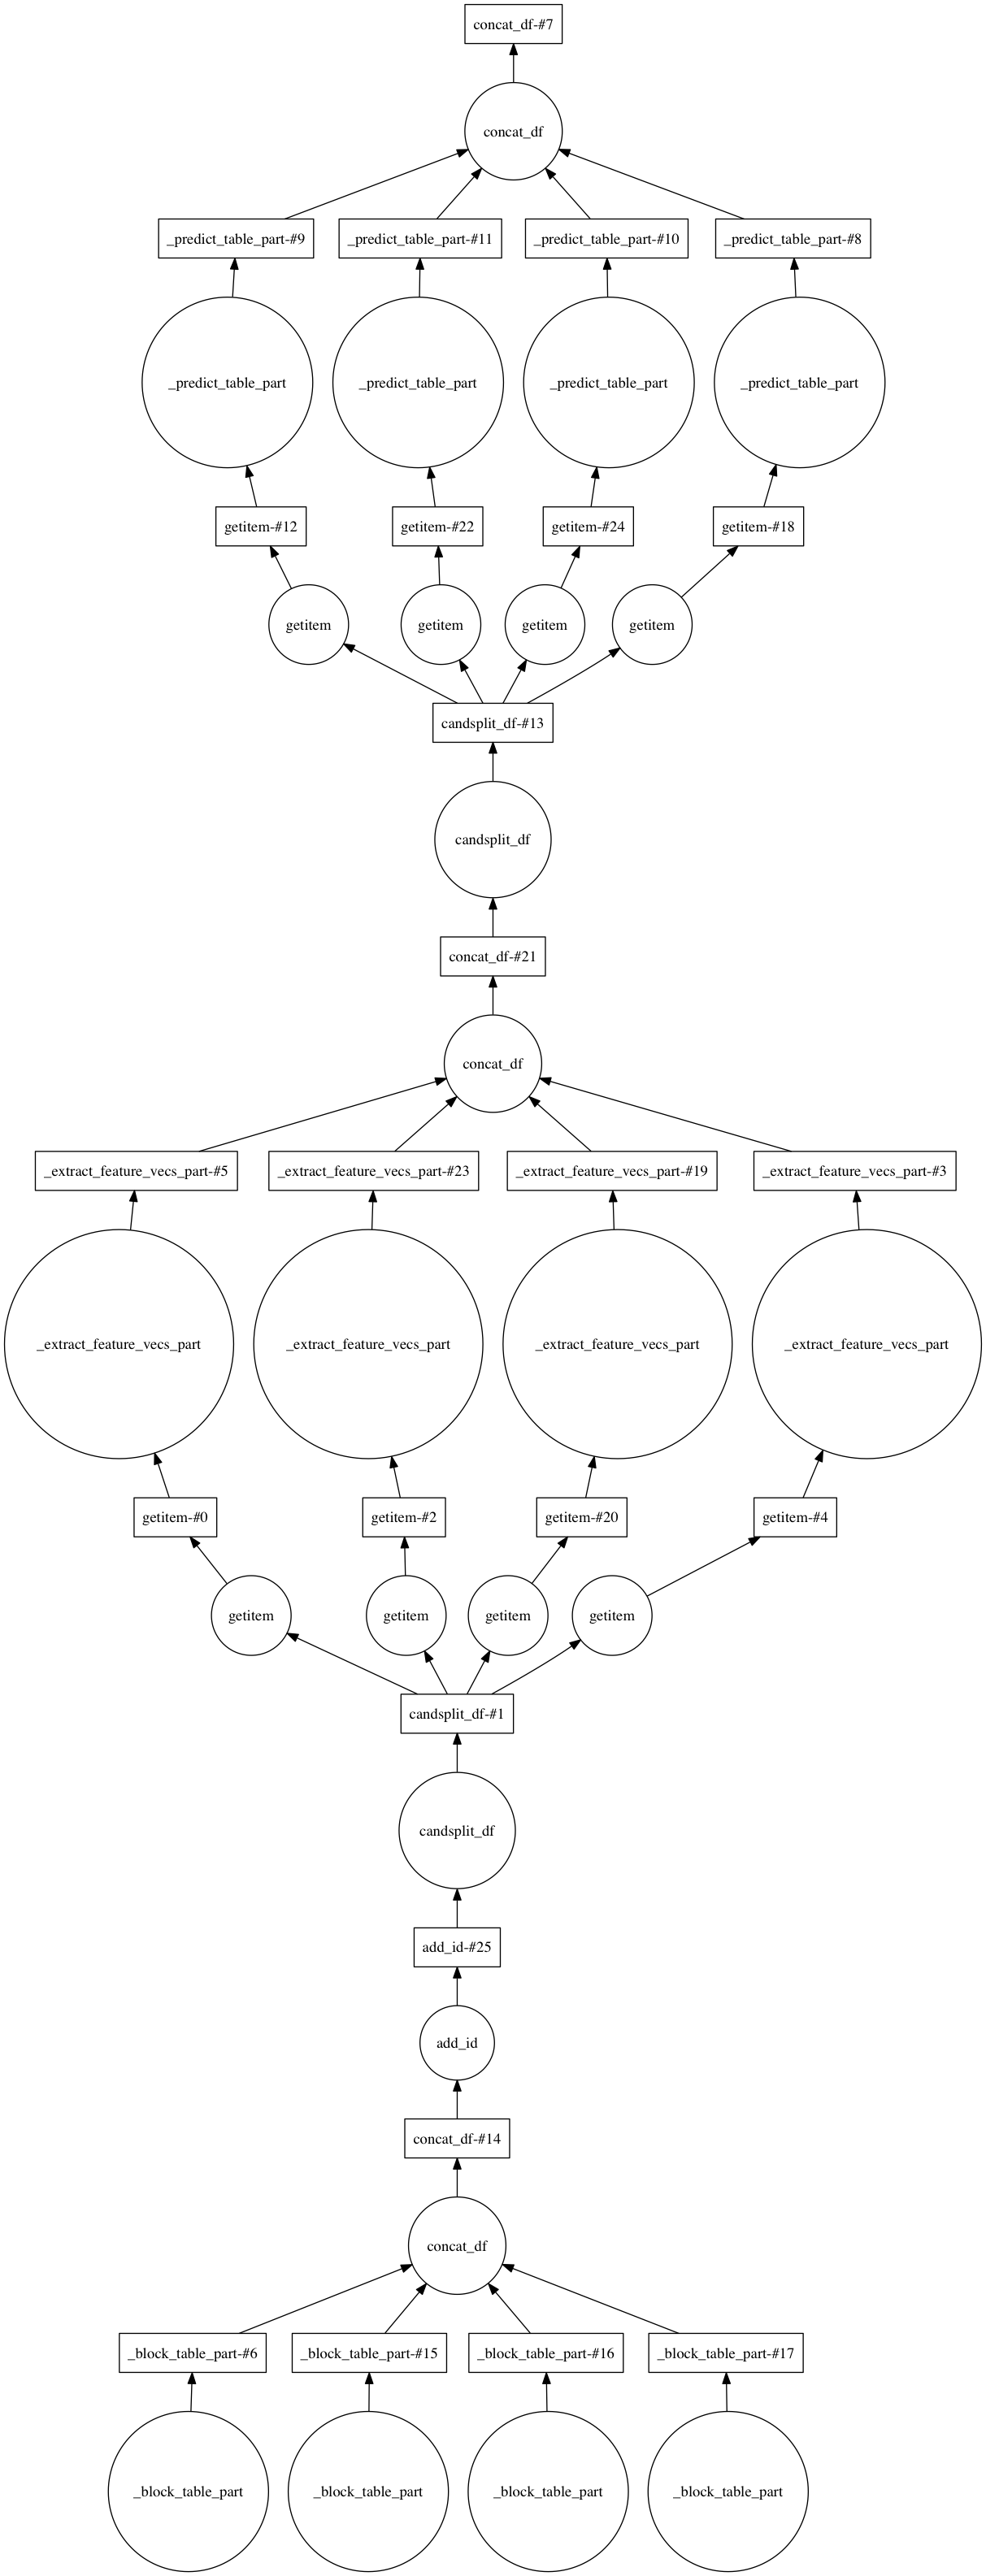

In [20]:
predictions.visualize()

In [21]:
p = predictions.compute(get=client.get)

In [22]:
# predictions.predicted.sum()

8